# Title

Importing relevant libraries

In [85]:
import numpy as num
import scipy as sci
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as skl
import xgboost
import gensim
import json
import re
import string
import seaborn as sns

Taking a fraction of the entire dataset

In [3]:
trainingAmount = 400000
testAmount = 100000

with open('review.json') as raw:
    with open('training.json', 'w') as trainingSet: 
        for x in range(trainingAmount):
            line = raw.readline()
            trainingSet.write(line)
    with open('test.json', 'w') as testSet: 
        for x in range(trainingAmount, trainingAmount+testAmount):
            line = raw.readline()
            testSet.write(line)

In [4]:
df_train = pd.read_json('training.json', lines=True)
df_test = pd.read_json('test.json', lines=True)

In [5]:
df_test = df_test.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_test = df_test.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train = df_train.drop("review_id", axis=1).drop("business_id", axis=1).drop("user_id", axis=1).drop("date", axis=1)
df_train = df_train.reindex(['text','stars','useful','funny','cool'], axis=1)

df_train['length'] = df_train['text'].apply(len)
df_test['length'] = df_test['text'].apply(len)

In [6]:
def clean(text):
     # Empty question
    if type(text) != str:
        return ''
    
#     nltk.corpus.stopwords.words('english')
    
    
    text = re.sub("I\'ll", "I will", text)
    text = re.sub("I\'m", "I am", text)

    text = text.lower()
    
    text = re.sub(" what\'s ", " what is ", text)
    text = re.sub(" that\'s ", " that is ", text)
    
    text = re.sub("\'s", "", text)
    
    
    text = re.sub(" whats ", " what is ", text)
    text = re.sub(" thats ", " that is ", text)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("n\'t", ' not', text)

    text = re.sub('[' + string.punctuation + ']', '', text)
    
    # remove comma between numbers, i.e. 15,000 -> 15000
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    
    # Return a list of words
    return text

In [12]:
df_train.describe()

,stars,useful,funny,cool
count,400000.000000,400000.000000,400000.000000,400000.000000
mean,3.730208,1.300900,0.451282,0.549493
std,1.455814,2.956285,1.676008,2.029620
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,135.000000,85.000000,108.000000


Cleaning the data

In [7]:
df_train['text'] = df_train['text'].apply(clean)
df_test['text'] = df_test['text'].apply(clean)

In [77]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

train = df_train['text'].values
test = df_test['text'].values

vectorizer = CountVectorizer()
trainVecs = vectorizer.fit_transform(train)
testVecs = vectorizer.transform(test)

trainStars = df_train['stars'].values
testStars = df_test['stars'].values

In [74]:
from sklearn.naive_bayes import MultinomialNB
classifierNB = MultinomialNB()
classifierNB.fit(trainVecs, trainStars)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [80]:
testStars_predicted = classifierNB.predict(testVecs)
print(classifierNB.score(testVecs, testStars)*100, "%")

60.407 %


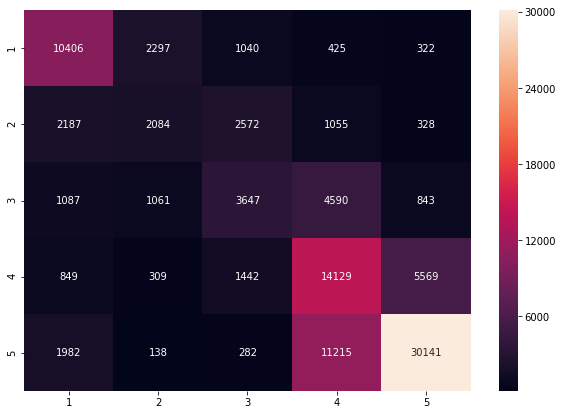

In [104]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testStars, testStars_predicted, labels=None, sample_weight=None)

df_cm = pd.DataFrame(confusion_matrix, index = [i for i in "12345"],
                  columns = [i for i in "12345"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [103]:
import collections
distance = num.abs(testStars - testStars_predicted)
collections.Counter(distance)

Counter({0: 60407, 1: 30933, 2: 4616, 4: 2304, 3: 1740})

### Looking for relation between text length and rating
Tests with charts

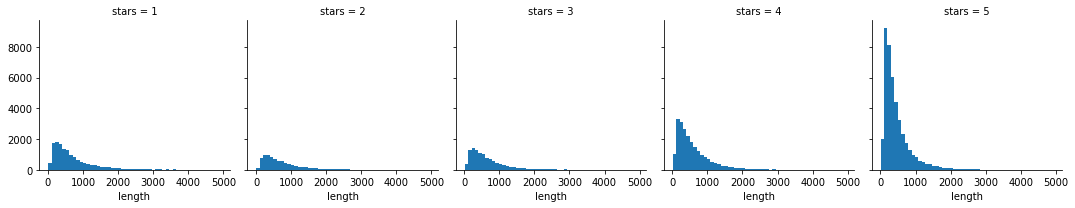

In [86]:
g = sns.FacetGrid(data=df_test, col='stars')
g.map(plt.hist, 'length', bins=50)

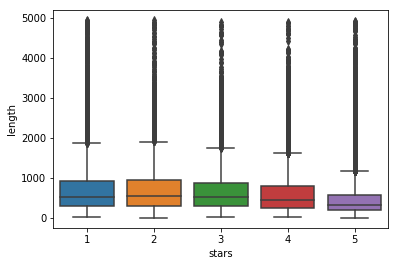

In [29]:
sns.boxplot(x='stars', y='length', data=df_test)

In [32]:
df_test.describe()

,stars,useful,funny,cool,length
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,3.726080,1.334980,0.461370,0.560660,582.731970
std,1.451891,3.071183,1.693002,2.061301,544.953497
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,231.000000
50%,4.000000,0.000000,0.000000,0.000000,414.000000
75%,5.000000,2.000000,0.000000,1.000000,741.000000
max,5.000000,201.000000,146.000000,203.000000,4932.000000


In [66]:
starProp_train = df_train.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_train['percentage'] = starProp_train['text'] / df_train.shape[0] * 100
starProp_train


,text,percentage
stars,,
1,58491,14.62275
2,32410,8.10250
3,44218,11.05450
4,88287,22.07175
5,176594,44.14850


In [67]:
starProp_test = df_test.groupby('stars').count().drop('useful', axis=1).drop('funny', axis=1).drop('cool', axis=1).drop('length', axis=1)
starProp_test['percentage'] = starProp_test['text'] / df_test.shape[0] * 100
starProp_test


,text,percentage
stars,,
1,14490,14.490
2,8226,8.226
3,11228,11.228
4,22298,22.298
5,43758,43.758


Training and test set have same proportions! :-)